## XGBOOST + LR (XGBOOST grid search)

XGBOOST + LR 是 CTR 常用的一种方式。

在 xgboost 直接调用 sklearn 的 grid search 函数时，没有办法使用 early stop。**使用 early stop 很有帮助**，一方面能够避免过拟合，另一方面能够节省不少时间，所以可以直接写个函数替代 grid search。下面代码中实现是逐个参数搜寻，逐个找到最优参数，实际上没有 grid search, 但是效果一般不会太差，而且省下很多时间。

- 1.分开数值特征与类别特征
- 2.自定义 xgb_grid_search 函数
- 3.利用最优的 xgb 模型把数值特征转为类别特征
- 4.将新特征和原始的类别特征一块训练 LR 模型进行最后的预测

In [1]:
# -*- coding:utf-8 -*-
from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV 

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import OneHotEncoder
import sys 
sys.path.append('../..')
import time
import my_utils

## 1.导入数据

In [2]:
# 特征名
column_names = ['0', '1', '2', '3', '4',
                '5', '6', '7','8', '9', 
                '10', '11', '12', '13',
                '14', '15', '16', '17', 
               ]

data = load_svmlight_file('../../raw_data/20171222_044846')
features = data[0].toarray()
labels = data[1]
print('features.shape=%s' % str(features.shape))
print('labels.shape=%s' % str(labels.shape))

features.shape=(73600, 18)
labels.shape=(73600,)


#### 分开类别特征和数值特征

In [3]:
df_data = pd.DataFrame(features, columns=column_names)
# 类别特征
col_no_id = ['0','1', '2', '3', 
             '4', '5', '6', '7', 
            '8', '9', '10', '11', '12']
col_is_id = list(set.difference(set(column_names), set(col_no_id)))

features_no_id = df_data.loc[:, col_no_id].values
features_is_id = list()
for col in col_is_id:
    features_is_id.append(pd.get_dummies(df_data[col].values).values)
features_is_id = np.hstack(features_is_id)
print('features_no_id.shape=%s' % str(features_no_id.shape))
print('features_is_id.shape=%s' % str(features_is_id.shape))

features = np.hstack([features_no_id, features_is_id])
n_no_id = len(col_no_id)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=3)

# 取数值型特征构建训练集
dtrain = xgb.DMatrix(X_train[:, :n_no_id], y_train, feature_names=col_no_id)
dtest = xgb.DMatrix(X_test[:, :n_no_id], y_test, feature_names=col_no_id)

features_no_id.shape=(73600, 13)
features_is_id.shape=(73600, 21)


##  2. 自定义xgboost 参数搜索函数

In [4]:
def model_fit(params, dtrain, max_round=300, cv_folds=5, n_stop_round=50):
    """对一组参数进行交叉验证，并返回最优迭代次数和最优的结果。
    Args:
        params: dict, xgb 模型参数。
        见 xgb_grid_search_cv 函数
        
    Returns: 
        n_round: 最优迭代次数
        mean_auc: 最优的结果
    """
    cv_result = xgb.cv(params, dtrain, max_round, nfold=cv_folds,
        metrics='auc', early_stopping_rounds=n_stop_round, show_stdv=False)
    n_round = cv_result.shape[0]  # 最优模型，最优迭代次数
    mean_auc = cv_result['test-auc-mean'].values[-1]  # 最好的  AUC
    return n_round, mean_auc


def xgb_grid_search_cv(params, key, search_params, dtrain, max_round=300, cv_folds=5, 
                       n_stop_round=50, return_best_model=True, verbose=True):
    """自定义 grid_search_cv for xgboost 函数。
    Args: 
        params: dict, xgb 模型参数。
        key: 待搜寻的参数。
        search_params：list, 待搜寻的参数list。
        dtrain： 训练数据
        max_round: 最多迭代次数
        cv_folds: 交叉验证的折数
        early_stopping_rounds: 迭代多少次没有提高则停止。
        return_best_model: if True, 在整个训练集上使用最优的参数训练模型。
        verbose：if True, 打印训练过程。
        
    Returns:
        cv_results: dict，所有参数组交叉验证的结果。
            - mean_aucs: 每组参数对应的结果。
            - n_rounds: 每组参数最优迭代轮数。
            - list_params: 搜寻的每一组参数。
            - best_mean_auc: 最优的结果。
            - best_round: 最优迭代轮数。
            - best_params: 最优的一组参数。
        best_model: XGBoostClassifer() 
    """  
    import time
    mean_aucs = list()
    n_rounds = list()
    list_params = list()
    print('Searching parameters: %s %s' % (key, str(values)))
    tic = time.time()
    for search_param in search_params:
        params[key] = search_param
        list_params.append(params.copy())
        n_round, mean_auc = model_fit(params, dtrain, max_round, cv_folds, n_stop_round)
        if verbose:
            print('%s=%s: n_round=%d, mean_auc=%g. Time cost %gs' % (key, str(search_param), n_round, mean_auc, time.time() - tic))
        mean_aucs.append(mean_auc)
        n_rounds.append(n_round)
    best_mean_auc = max(mean_aucs)
    best_index = mean_aucs.index(best_mean_auc)  # 最优的一组
    best_round = n_rounds[best_index]
    best_params = list_params[best_index]
    cv_result = {'mean_aucs': mean_aucs, 'n_rounds': n_rounds, 'list_params': list_params, 
                'best_mean_auc': best_mean_auc, 'best_round': best_round, 'best_params': best_params}
    if return_best_model:       
        best_model = xgb.train(best_params, dtrain, num_boost_round=best_round)
    else:
        best_model = None
    if verbose:
        print('best_mean_auc = %g' % best_mean_auc)
        print('best_round = %d' % best_round)
        print('best_params = %s' % str(best_params))
    return cv_result, best_model

In [5]:
params = {'booster': 'gbtree',
          'objective': 'binary:logistic',
          'learning_rate': 0.1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'eta': 0.1,
          'max_depth': 5,
          'min_child_weight': 1,
          'gamma': 0.0,
          'silent': 1,
          'seed': 0,
          'eval_metric': 'auc',
          'njob':8
          }
key = 'learning_rate'
values = [0.05, 0.1]
cv_result, best_model = xgb_grid_search_cv(params, key, values, dtrain)
print('%s: %s' % (key, str(values)))
print('n_round = %s' % str(cv_result['n_rounds']))
print('mean_aucs = %s' % str(cv_result['mean_aucs']))

Searching parameters: learning_rate [0.05, 0.1]
learning_rate=0.05: n_round=52, mean_auc=0.534587. Time cost 78.1885s
learning_rate=0.1: n_round=43, mean_auc=0.539724. Time cost 161.781s
best_mean_auc = 0.539724
best_round = 43
best_params = {'colsample_bytree': 0.8, 'silent': 1, 'eval_metric': 'auc', 'eta': 0.1, 'learning_rate': 0.1, 'njob': 8, 'min_child_weight': 1, 'subsample': 0.8, 'seed': 0, 'objective': 'binary:logistic', 'max_depth': 5, 'gamma': 0.0, 'booster': 'gbtree'}
learning_rate: [0.05, 0.1]
n_round = [52, 43]
mean_aucs = [0.53458660000000002, 0.53972360000000008]


在上一个参数最优的基础上，寻找其他参数的最优值.

这样并没有完全进行 grid search，但是一般来说，结果不会太差

In [6]:
params = cv_result['best_params']
key = 'max_depth'
values = [3, 4, 5]
cv_result, best_model = xgb_grid_search_cv(params, key, values, dtrain)
print('%s: %s' % (key, str(values)))
print('n_round = %s' % str(cv_result['n_rounds']))
print('mean_aucs = %s' % str(cv_result['mean_aucs']))

Searching parameters: max_depth [3, 4, 5]
max_depth=3: n_round=42, mean_auc=0.537475. Time cost 68.5076s
max_depth=4: n_round=43, mean_auc=0.537731. Time cost 159.202s
max_depth=5: n_round=43, mean_auc=0.539724. Time cost 242.507s
best_mean_auc = 0.539724
best_round = 43
best_params = {'colsample_bytree': 0.8, 'silent': 1, 'eval_metric': 'auc', 'learning_rate': 0.1, 'njob': 8, 'min_child_weight': 1, 'subsample': 0.8, 'eta': 0.1, 'objective': 'binary:logistic', 'seed': 0, 'max_depth': 5, 'gamma': 0.0, 'booster': 'gbtree'}
max_depth: [3, 4, 5]
n_round = [42, 43, 43]
mean_aucs = [0.53747460000000002, 0.53773139999999997, 0.53972360000000008]


In [7]:
# 使用 xgb_model.predict() 返回每个样本分为 正类 1 的概率
y_pred_prob = best_model.predict(dtest)
print(X_test.shape, y_pred_prob.shape)
print(y_pred_prob[0])
# 设置 pred_leaf=True, 返回每个样本在每棵树上的叶子的 ID
y_pred_prob = best_model.predict(dtest, pred_leaf=True)
print(X_test.shape, y_pred_prob.shape)
print(y_pred_prob[0])

(14720, 34) (14720,)
0.0124127
(14720, 34) (14720, 43)
[ 0  0  0  0  0  0  0  0  0  0  0  1  1  3  3  3  3  7  7  3  3  8  1  7  3
  1 19  7 15 23 31 37 37 27 19 15 29 25 25 23 31 28 25]


## 3. 将所有的数值特征转为 one-hot 类型，和原始的类别型特征进行拼接

In [8]:
# 编码成 one-hot 类型的数据
grd_enc = OneHotEncoder()
# LR 分类器
grd_lm = LogisticRegression()
# 每棵树的叶子编码
dall = xgb.DMatrix(features[:, :n_no_id], feature_names=col_no_id)
all_leafs = best_model.predict(dall, pred_leaf=True)
train_leafs = best_model.predict(dtrain, pred_leaf=True)
test_leafs = best_model.predict(dtest, pred_leaf=True)

# 使用所有特征确定编码规则
grd_enc.fit(all_leafs)
# one-hot 编码
oh_train = grd_enc.transform(train_leafs).toarray()
oh_test = grd_enc.transform(test_leafs).toarray()

In [9]:
# 所有特征
X_train_oh = np.hstack([oh_train, X_train[:, n_no_id:]])
X_test_oh = np.hstack([oh_test, X_test[:, n_no_id:]])
print('X_train_oh.shape=%s' % str(X_train_oh.shape))
print('X_test_oh.shape=%s' % str(X_test_oh.shape))

X_train_oh.shape=(58880, 492)
X_test_oh.shape=(14720, 492)


### 使用 LR 进行训练

In [10]:
# 使用 LR 进行训练
C_params = np.linspace(0.001, 0.05, 10)  # 线性划分参数，0.001--5 ，划分20等分  # 0.015  最好

LR_aucs = []  # 存储cv值
print(C_params)
tic = time.time()
for C_param in C_params:
    model = LogisticRegression(C = C_param, penalty='l2', max_iter=300)
    scores = cross_val_score(model, X_train_oh, y_train, cv=5, scoring='roc_auc')
    LR_aucs.append(scores.mean())
    print('C=%g, mean_auc = %g. Time passed %gs' % (C_param, scores.mean(), time.time() - tic))
print("mean_aucs，", LR_aucs)
print("参数，", params)
best_index = LR_aucs.index(max(LR_aucs))
print("最好的参数:", C_params[best_index])
print("best_auc = %g" %  max(LR_aucs))

# 使用最好的参数训练最后的模型
LR = LogisticRegression(C=C_params[best_index], penalty='l2', max_iter=100)
LR.fit(X_train_oh, y_train)

[ 0.001       0.00644444  0.01188889  0.01733333  0.02277778  0.02822222
  0.03366667  0.03911111  0.04455556  0.05      ]
C=0.001, mean_auc = 0.553148. Time passed 2.44328s
C=0.00644444, mean_auc = 0.602253. Time passed 5.5303s
C=0.0118889, mean_auc = 0.612432. Time passed 9.12239s
C=0.0173333, mean_auc = 0.617869. Time passed 12.936s
C=0.0227778, mean_auc = 0.62137. Time passed 16.7762s
C=0.0282222, mean_auc = 0.62381. Time passed 20.8325s
C=0.0336667, mean_auc = 0.626271. Time passed 24.9229s
C=0.0391111, mean_auc = 0.627935. Time passed 29.262s
C=0.0445556, mean_auc = 0.629926. Time passed 33.1962s
C=0.05, mean_auc = 0.631066. Time passed 36.6805s
mean_aucs， [0.55314761462526785, 0.60225338755439206, 0.61243187424031753, 0.61786885529608182, 0.62137038918338783, 0.62381028779844427, 0.62627065614627997, 0.62793456864639041, 0.62992609163644286, 0.63106630566612487]
参数， {'colsample_bytree': 0.8, 'silent': 1, 'eval_metric': 'auc', 'eta': 0.1, 'learning_rate': 0.1, 'njob': 8, 'min_chi

LogisticRegression(C=0.050000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

###  最后进行预测

[ 0.00334971  0.00522246  0.00536675  0.00698756  0.00590602  0.0045314
  0.00749942  0.00565166  0.0058966   0.00505731]


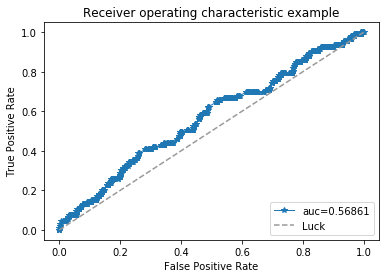

In [11]:
# 预测
y_pred_prob = LR.predict_proba(X_test_oh)[:, 1]
print(y_pred_prob[:10])
# 绘制 ROC 曲线，计算 AUC
roc_auc, fpr, tpr, thresholds = my_utils.get_auc(y_test, y_pred_prob, plot_ROC=True)

利用 GBDT+LR 融合的方案有很多好处，利用 GDBT 主要是**发掘有区分度的 特征和特征组合**：
- LR 模型无法实现特征组合，但是模型中特征组合很关键，依靠人工经验非常耗时而且不一定能有好的效果。利用 GBDT 可以自动发现有效的特征、特征组合。GBDT 每次迭代都是在减少残差的梯度方向上面新建一棵决策树，GBDT 的每个叶子结点对应一个路径，也就是一种组合方式。
- 由于树的每条路径都是最小化均方误差等方法算出来的，得到的路径（特征组合）具有区分度不亚于人工经验

参考：
- [【总结】CTR预估中GBDT与LR融合方案](http://blog.csdn.net/dengxing1234/article/details/73739481)